In [1]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ts = pd.read_excel("data/stock_prices.xlsx", usecols = ["Date", "Adj Close", "Volume"])

In [4]:
# Check for stationarity

In [5]:
result = adfuller(ts["Adj Close"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # Non-stationary -> need to differentiate

ADF Statistic: -1.522240
p-value: 0.522482


In [6]:
ts["Close_Diff"] = ts["Adj Close"].diff()

In [7]:
result = adfuller(ts["Close_Diff"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # Stationary

ADF Statistic: -11.104181
p-value: 0.000000


/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


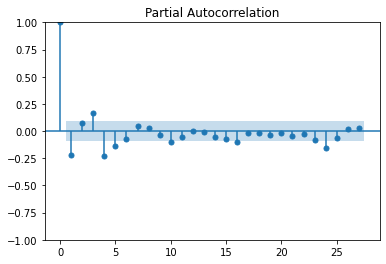

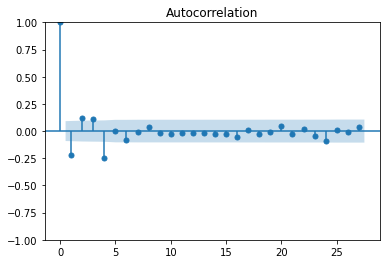

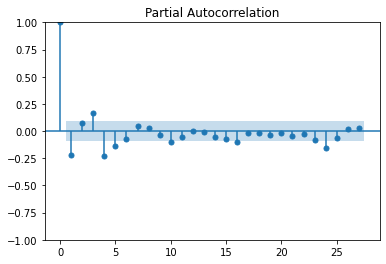

In [8]:
plot_acf(ts.Close_Diff.dropna())
plot_pacf(ts.Close_Diff.dropna())

In [9]:
# Build model and implement rolling window (= ExpandingWindowSplitter) for hyperparameter tuning

In [10]:
# Train, test split
series = ts["Close_Diff"].dropna()
train_size = int(round(len(series) * 0.90, 0))

train = series[:train_size]
y_test = list(series[train_size:])

# Train, val split
train_size2 = int(round(len(train) * 0.90, 0))
y_train = list(train[:train_size2])
y_val = list(train[train_size2:])

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_rolling_forecast(train, val, params):
    history = [x for x in train]
    predictions = list()
    for t in range(len(val)):
        model = ARIMA(history, order=params)
        model_fit = model.fit(return_params=False)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = val[t]
        history.append(obs)
        # print("%d/%d predicted=%f, expected=%f" % (t, len(val), yhat, obs))
    rmse = mean_squared_error(val, predictions, squared = True)
    mse = mean_squared_error(val, predictions, squared = False)
    mae = mean_absolute_error(val, predictions)

    return rmse, mse, mae, predictions, val

In [12]:
# p: The number of lag observations included in the model, also called the lag order.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average.

para = [(5,0,0), (1,0,1), (2,0,2), (0,0,5), (1,0,0), (0,0,1), (0,0,0)]

In [13]:
para = [(1,0,0)]

In [14]:
history = []
for p in para:
    rmse, mse, mae, _, _ = run_rolling_forecast(y_train, y_val, p)
    s = "Params: " + str(p) + ";RMSE: " + str(rmse) + ";MSE:" + str(mse) + ";MAE:" + str(mae)
    history.append(s)

In [15]:
# Find best parameters
for item in history:
    print(item)

Params: (1, 0, 0);RMSE: 41.195749725240894;MSE:6.4183915216540735;MAE:5.000929255325214


In [16]:
# Hypothetically now, select best later on
best_param = (1, 0, 0)

In [17]:
y_train_final = y_train + y_val

In [18]:
rmse, mse, mae, y_pred, test = run_rolling_forecast(y_train_final, y_test, best_param)

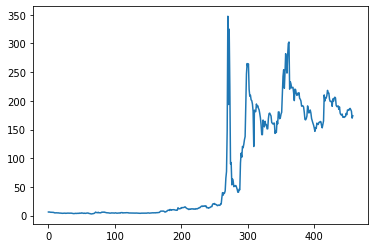

In [20]:
# Plot actual stock price
from matplotlib import pyplot
pyplot.plot(ts["Adj Close"])

In [22]:
# Inverse Diff

In [84]:
def diff_inv(series_diff, first_value):
    series_inverted = list(np.r_[first_value, series_diff].cumsum().astype('float64'))
    return series_inverted

In [105]:
np.array(y_test).cumsum()

array([ 6.40000916, 11.99000549, 57.38999939, 46.75      , 52.32000732,
       52.05000305, 56.30000305, 65.3400116 , 60.07000732, 60.62001038,
       49.8500061 , 46.1000061 , 45.90000916, 46.27999878, 37.51000977,
       50.5       , 46.3400116 , 51.62001038, 53.47000122, 52.07000732,
       39.30000305, 37.05000305, 37.24000549, 38.3400116 , 32.26000977,
       36.58000183, 25.70001221, 23.02000427, 22.57000732, 24.01000977,
       18.46000671, 19.27999878, 18.17001343, 19.22000122, 19.77999878,
       25.20001221, 22.92001343, 31.16000366, 30.93000793, 30.38000488,
       33.12001038, 33.88999939, 31.62001038, 28.81001282, 16.90000916,
       21.07000732])

In [114]:
LAST_OBSERVED_VALUE_BEFORE_TEST_SET = ts["Adj Close"][len(y_train_final)]
plt_test = diff_inv(y_test, LAST_OBSERVED_VALUE_BEFORE_TEST_SET)
plt_pred = diff_inv(y_pred, LAST_OBSERVED_VALUE_BEFORE_TEST_SET)
plt_train = diff_inv(y_train, LAST_OBSERVED_VALUE_BEFORE_TEST_SET)

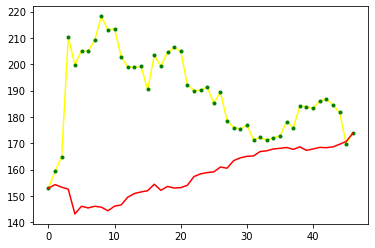

In [129]:
# Plot Price Data
pyplot.plot(ts["Adj Close"].values[len(y_train_final):], '-', color = "yellow")
pyplot.plot(plt_test, '.', color = "green")
pyplot.plot(plt_pred, color = "red")
# Can confirm that the correct last observed value was selected

In [130]:
rmse = mean_squared_error(y_test, plt_test[1:], squared = True)
mse = mean_squared_error(y_test, plt_test[1:], squared = False)
mae = mean_absolute_error(y_test, plt_test[1:])

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 35826.4334155478
MSE: 189.2787188659829
MAE: 188.6560871290124


In [131]:
len(y_train_final)+len(y_pred)

458

In [132]:
len(y_train_final)

412

In [137]:
testPredictPlot = np.empty_like(ts["Adj Close"])
testPredictPlot[:] = np.nan
testPredictPlot[len(y_train_final):] = plt_pred

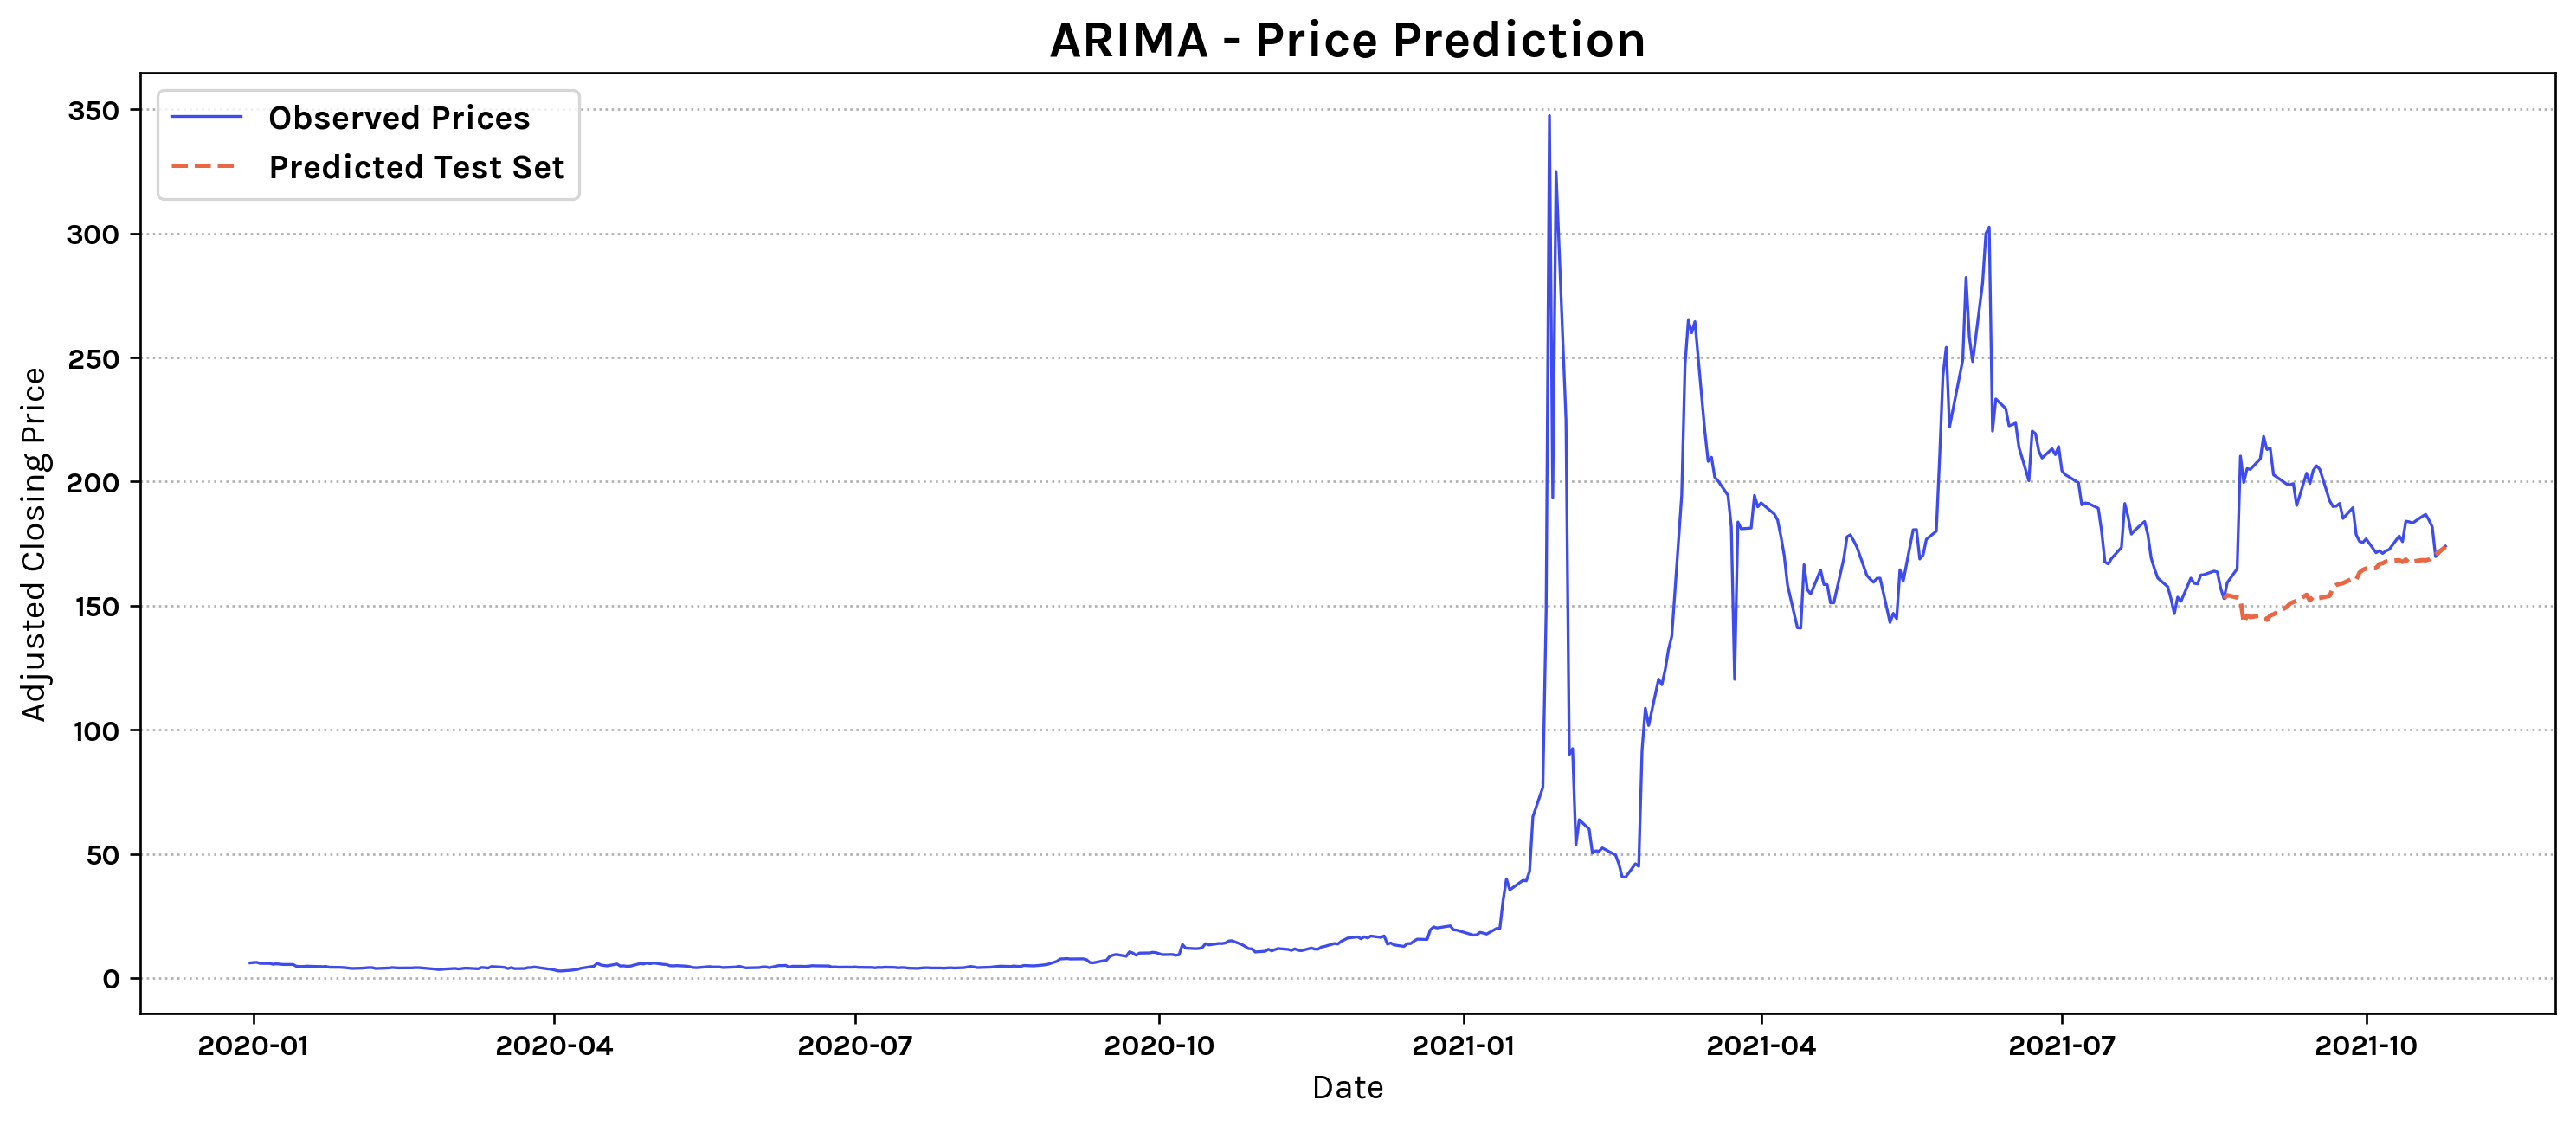

In [141]:
plt.rcParams['font.sans-serif'] = "Karla"
plt.rcParams["font.weight"] = "bold"

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=240)

x = ts.Date
plt.plot(x, ts["Adj Close"], color = "#3F4CEC", linewidth = 1, label = "Observed Prices")
plt.plot(x, testPredictPlot, color = "#E96744", linestyle='dashed', label = "Predicted Test Set")
plt.legend(loc="upper left", prop={'size': 12})
plt.ylabel("Adjusted Closing Price", fontsize = 12)
plt.grid(axis = "y", linestyle = "dotted")
plt.xlabel("Date", fontsize = 12)
plt.title("ARIMA - Price Prediction", fontsize = 18, weight = "bold")
plt.show()